In [1]:
# Packages loading
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neural_network import MLPRegressor

In [2]:
# data read in
data = pd.read_parquet("day0_data_cleaned.parquet")

In [3]:
# checking data
print(data.info())  
print(data.describe())  
print(data.head())  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1944210 entries, 0 to 1944209
Data columns (total 57 columns):
 #   Column       Dtype  
---  ------       -----  
 0   date_id      int16  
 1   time_id      int16  
 2   symbol_id    int8   
 3   weight       float32
 4   feature_05   float32
 5   feature_06   float32
 6   feature_07   float32
 7   feature_08   float32
 8   feature_09   int8   
 9   feature_10   int8   
 10  feature_11   int16  
 11  feature_16   float32
 12  feature_18   float32
 13  feature_19   float32
 14  feature_20   float32
 15  feature_22   float32
 16  feature_23   float32
 17  feature_25   float32
 18  feature_28   float32
 19  feature_30   float32
 20  feature_32   float32
 21  feature_33   float32
 22  feature_35   float32
 23  feature_36   float32
 24  feature_38   float32
 25  feature_39   float32
 26  feature_42   float32
 27  feature_44   float32
 28  feature_45   float32
 29  feature_46   float32
 30  feature_47   float32
 31  feature_48   float32
 32

In [4]:
# Define the target variable
target_column = "responder_6"
feature_column = [col for col in data.columns if col.startswith('feature')]

# Separate input features and target variable
X = data[feature_column]
y = data[target_column]
print(f"Features shape: {X.shape}, Target shape: {y.shape}")

Features shape: (1944210, 52), Target shape: (1944210,)


In [5]:
# train/test data split(80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# set MLP Regression model
mlp = MLPRegressor(
    hidden_layer_sizes=(128, 64),  
    activation='relu',             
    solver='adam',                 
    alpha=0.0001,                  
    learning_rate='adaptive',       
    max_iter=500,                   
    random_state=42
)

In [ ]:
# 6. 进行 5 fold cross validation
cv = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(mlp, X_train, y_train, cv=cv, scoring='neg_root_mean_squared_error')

print(f"cross validation RMSE mean: {-np.mean(cv_scores):.4f}, standard dev: {np.std(cv_scores):.4f}")

交叉验证 RMSE 均值: 0.8145, 标准差: 0.0030


In [8]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

In [9]:

# Random Search
# We are not using grid search here because MLP is complicated and it took too long time.
param_dist = {
    'hidden_layer_sizes': [(64, 32), (128, 64)],
    'alpha': uniform(0.0001, 0.01),  
    'learning_rate_init': uniform(0.001, 0.1)  
}

random_search = RandomizedSearchCV(
    estimator=MLPRegressor(max_iter=500, activation='relu', solver='adam', random_state=42),
    param_distributions=param_dist,
    n_iter=5,  # only search 5 group parameters randomly
    scoring='neg_root_mean_squared_error',
    cv=3,  # 3 fold cross validation
    verbose=1,
    n_jobs=-1,
    random_state=42
)

random_search.fit(X_train, y_train)

# getting best hyperparameter
best_params = random_search.best_params_
print("Best Hyperparameter:", best_params)


Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best Hyperparameter: {'alpha': np.float64(0.007896910002727693), 'hidden_layer_sizes': (64, 32), 'learning_rate_init': np.float64(0.01660186404424365)}


In [ ]:
# Using best params to train final model
final_model = MLPRegressor(**best_params, max_iter=1000, activation='relu', solver='adam', random_state=42)
final_model.fit(X_train, y_train)

# predict
y_pred = final_model.predict(X_test)

In [ ]:
# RMSE and R² score
rmse_score = mean_squared_error(y_test, y_pred)**0.5
r2 = r2_score(y_test, y_pred)

print(f"test set RMSE: {rmse_score:.4f}")
print(f"test set R²: {r2:.4f}")

测试集 RMSE: 0.8715
测试集 R²: -0.0002


In [ ]:
# model stability check(multi-time training)
stability_scores = []
for i in range(10):  
    temp_model = MLPRegressor(**best_params, max_iter=1000, activation='relu', solver='adam', random_state=i)
    temp_model.fit(X_train, y_train)
    temp_pred = temp_model.predict(X_test)
    stability_scores.append(mean_squared_error(y_test, temp_pred)**0.5)

print(f"model stability(mean RMSE): {np.mean(stability_scores):.4f}, standard error: {np.std(stability_scores):.4f}")

model stability(mean RMSE): 0.8719, standard error: 0.0004


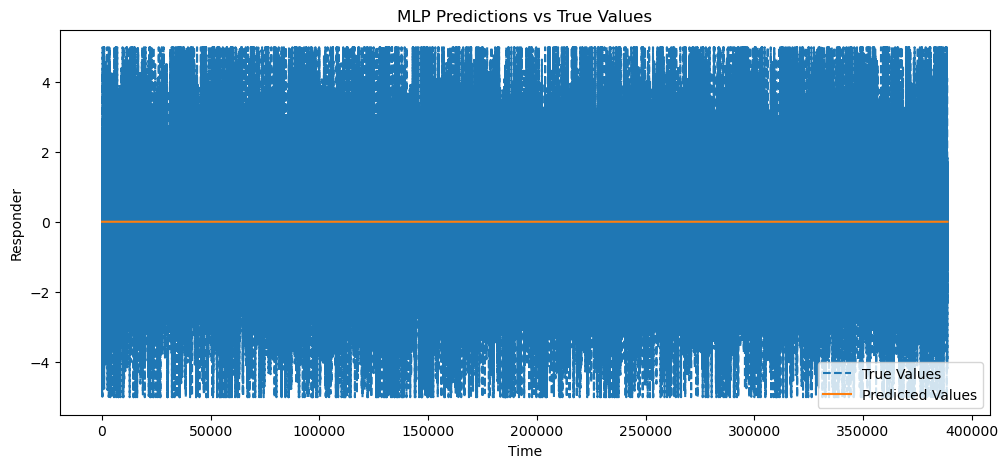

In [13]:
import matplotlib.pyplot as plt

# results visualization
plt.figure(figsize=(12, 5))
plt.plot(y_test.values, label="True Values", linestyle="dashed")
plt.plot(y_pred, label="Predicted Values")
plt.xlabel("Time")
plt.ylabel("Responder")
plt.legend()
plt.title("MLP Predictions vs True Values")
plt.show()


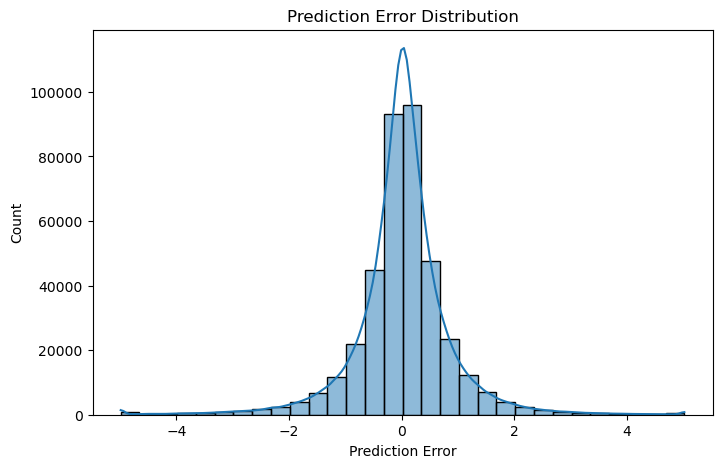

In [14]:
import seaborn as sns

# Error distribution
errors = y_pred - y_test.values

# plot
plt.figure(figsize=(8, 5))
sns.histplot(errors, bins=30, kde=True)
plt.xlabel("Prediction Error")
plt.title("Prediction Error Distribution")
plt.show()


In [16]:
import shap
import numpy as np

100%|██████████| 50/50 [00:22<00:00,  2.21it/s]


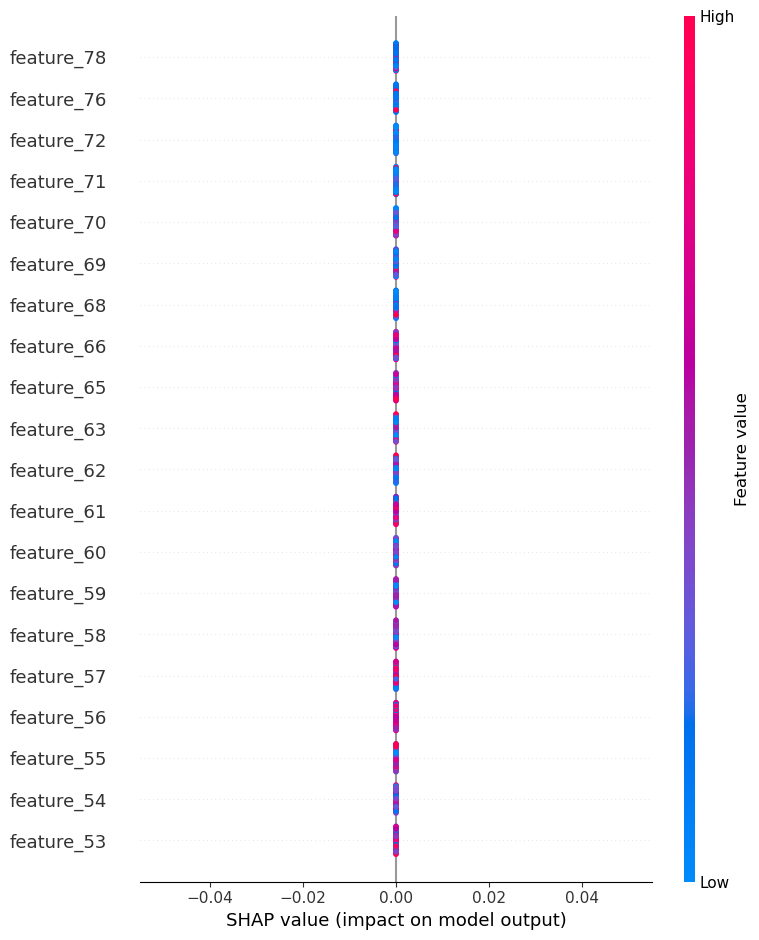

In [18]:
# taking only a sample part of test set data to smallerize calculation time
background = X_train.sample(100, random_state=42)

# Use KernelExplainer to do SHAP
explainer = shap.KernelExplainer(final_model.predict, background)
shap_values = explainer.shap_values(X_test.sample(50, random_state=42))  # only 50 samples to accelerate

# SHAP summary plot
shap.summary_plot(shap_values, X_test.sample(50, random_state=42))
